# Imports 

In [161]:
import cv2
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial as spatial
from scipy.spatial import distance
import matplotlib.image as mpimg
import scipy.cluster as cluster
from collections import defaultdict
from PIL import Image
from itertools import product
from statistics import mean

# Help Functions

In [162]:
# the function extract from the video in the path_to_video frames.
# suspension is a parameter that control the number of frames extract from the video. 

def read_video_and_save_frames(path_to_video, path_to_frames):
    
    suspension = 1000
    vidcap = cv2.VideoCapture(path_to_video)
    success,image = vidcap.read()
    count = 0
    success = True
    while success:
        image = cv2.flip(image,-1)
        cv2.imwrite(path_to_frames + "/frame%d.jpg" % count, image)     # save frame as JPEG file
        vidcap.set(cv2.CAP_PROP_POS_MSEC,(count*suspension))    # added this line 
        success,image = vidcap.read()
        count = count + 1    

In [163]:
def extrapolate_7_7_to_9_9_corners(corners7):
    # Initialize the board with dots:
    full_corners = np.zeros((9,9,2))
    full_corners[1:-1,1:-1] = corners7
    full_corners[0,:,0] = full_corners[1,:,0]  - (full_corners[2,:,0] - full_corners[1,:,0]) 
    full_corners[0,:,1] = full_corners[1,:,1]  - (full_corners[2,:,1] - full_corners[1,:,1])

    full_corners[8,:,0] = full_corners[7,:,0]  - (full_corners[6,:,0] - full_corners[7,:,0]) 
    full_corners[8,:,1] = full_corners[7,:,1]  - (full_corners[6,:,1] - full_corners[7,:,1])

    full_corners[:,0,0] = full_corners[:,1,0]  - (full_corners[:,2,0] - full_corners[:,1,0]) 
    full_corners[:,0,1] = full_corners[:,1,1]  - (full_corners[:,2,1] - full_corners[:,1,1])

    full_corners[:,8,0] = full_corners[:,7,0]  - (full_corners[:,6,0] - full_corners[:,7,0]) 
    full_corners[:,8,1] = full_corners[:,7,1]  - (full_corners[:,6,1] - full_corners[:,7,1])
    
    return full_corners

In [164]:
# y = mx + c
# y = Ap, where A = [[x 1]] and p = [[m], [c]]
def tune_using_LS(x,y):
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    y_new = (m * x) + c
    return y_new

In [165]:
def full_corners_refined_tuning(full_corners):
    full_corners_new = np.zeros((9,9,2))
    full_corners_new[:,:,:] = full_corners[:,:,:]

    #tune upper and downer lines
    full_corners_new[:,0,1] = tune_using_LS(full_corners[:,0,0], full_corners[:,0,1]) #tune down line 
    full_corners_new[:,8,1] = tune_using_LS(full_corners[:,8,0], full_corners[:,8,1]) #tune up line 

    #tune left to right vertical lines
    for i in range(0,8):
        full_corners_new[i,:,0] = tune_using_LS(full_corners[i,:,1], full_corners[i,:,0]) #tune up line 

    #tune up to down horizontal lines
    for i in range(0,8):
        full_corners_new[:,i,1] = tune_using_LS(full_corners[:,i,0], full_corners[:,i,1]) #tune up line 
    
    return full_corners_new

In [166]:
def extract_squares_from_tuned_corners(full_corners_new):
    squares = np.zeros((8,8,4))
    for i in range(0,8):
        for j in range(0,8):
            a = full_corners_new[i,j,:] # black
            b = full_corners_new[i,j+1,:] # red
            c = full_corners_new[i+1,j,:] # green
            d = full_corners_new[i+1,j+1,:] # pink
            slant1 = distance.euclidean(a, d) 
            slant2 = distance.euclidean(c, b)
            if slant1 < slant2:   
                squares[i,j,0] = a[1]
                squares[i,j,1] = d[1]
                squares[i,j,2] = d[0] 
                squares[i,j,3] = a[0]
            else:
                squares[i,j,0] = c[1]
                squares[i,j,1] = b[1]
                squares[i,j,2] = c[0]
                squares[i,j,3] = b[0] 
    return squares

In [167]:
def create_squares_names(scaling):
    squares_names = np.empty((8, 8), dtype=object)
    if scaling == "h1": 
        first_idx = ['h', 'g', 'f', 'e', 'd', 'c', 'b', 'a']
        second_idx = np.array(range(1,9))
    elif scaling == "a1": 
        first_idx = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
        second_idx = np.array(range(1,9))
    elif scaling == "a8":
        first_idx = np.array(range(8,0,-1))
        second_idx = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
    else: #h8
        first_idx = np.array(range(8,0,-1))
        second_idx = ['h', 'g', 'f', 'e', 'd', 'c', 'b', 'a']
    for i in range(0,8):
        for j in range(0,8):
            if scaling == "a8":
                squares_names[i,j] = str(second_idx[j]) + str(first_idx[i])
            else: 
                squares_names[i,j] = str(first_idx[j]) + str(second_idx[i])
    return squares_names

In [168]:
def initialize_pices_on_board(squares_names):
    pieces_locations = np.empty((8, 8), dtype=object)
    black_k = ['B_R', 'B_N', 'B_B', 'B_Q', 'B_K', 'B_B', 'B_N', 'B_R']
    black_k_idx = [str(i)+'8' for i in ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']]
    black_p_idx = [str(i)+'7' for i in ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']]
    white_k = ['W_R', 'W_N', 'W_B', 'W_Q', 'W_K', 'W_B', 'W_N', 'W_R']
    white_k_idx = [str(i)+'1' for i in ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']]
    white_p_idx = [str(i)+'2' for i in ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']]
    
    for i in range(0,8):
        where_black_k_idx = np.where(squares_names == black_k_idx[i])
        pieces_locations[where_black_k_idx[0][0],where_black_k_idx[1][0]] = black_k[i]

        where_white_k_idx = np.where(squares_names == white_k_idx[i])
        pieces_locations[where_white_k_idx[0][0],where_white_k_idx[1][0]] = white_k[i]
        
        where_black_p_idx = np.where(squares_names == black_p_idx[i])
        pieces_locations[where_black_p_idx[0][0],where_black_p_idx[1][0]] = 'B_P'
        
        where_white_p_idx = np.where(squares_names == white_p_idx[i])
        pieces_locations[where_white_p_idx[0][0],where_white_p_idx[1][0]] = 'W_P'

    return pieces_locations

In [169]:
def mean_of_squares(img, squares):
    squares_mean = np.zeros((8,8))
    for i in range(0,8):
        for j in range(0,8):
            squares_mean[i,j] = np.mean(img[int(squares[i,j,0])+3:int(squares[i,j,1])-3, int(squares[i,j,2])+3:int(squares[i,j,3])-3])
    return squares_mean

In [170]:
def find_move_algebraic_notation(from_idx1, from_idx2, to_idx1, to_idx2, squares_names, pieces_locations):

    move_algebric_notation = ''
    if pieces_locations[to_idx1,to_idx2] == None:
        if not(pieces_locations[from_idx1,from_idx2] == 'W_P' or pieces_locations[from_idx1,from_idx2] == 'B_P'):
            #other piece no capture
            move_algebric_notation = pieces_locations[from_idx1,from_idx2][2]
    else:
        if pieces_locations[from_idx1,from_idx2] == 'W_P' or pieces_locations[from_idx1,from_idx2] == 'B_P':
            #pawn capture someting
            move_algebric_notation = squares_names[from_idx1,from_idx2][0] + 'x' 
            
        else:
            #other piece capture someting
            move_algebric_notation = pieces_locations[from_idx1,from_idx2][2] + 'x' 
        
    move_algebric_notation = move_algebric_notation + squares_names[to_idx1,to_idx2]
    pieces_locations_new = pieces_locations.copy()
    pieces_locations_new[to_idx1, to_idx2] = pieces_locations_new[from_idx1, from_idx2]
    pieces_locations_new[from_idx1, from_idx2] = None
    
    return move_algebric_notation, pieces_locations_new

In [171]:
def test_if_move_is_leagal(from_idx1, from_idx2, to_idx1, to_idx2, pieces_locations, white_move):
    new_from_idx1, new_from_idx2 = from_idx1,from_idx2
    new_to_idx1, new_to_idx2 = to_idx1,to_idx2
    
    if (pieces_locations[from_idx1,from_idx2] == None) or (pieces_locations[from_idx1,from_idx2][0] == "W" and white_move != True) or (pieces_locations[from_idx1,from_idx2][0] == "B" and white_move != False):
        if pieces_locations[to_idx1,to_idx2] != None and ((pieces_locations[to_idx1,to_idx2][0] == "W" and white_move == True) or (pieces_locations[to_idx1,to_idx2][0] == "B" and white_move == False)):
            new_from_idx1 = to_idx1
            new_from_idx2 = to_idx2
            new_to_idx1 = from_idx1
            new_to_idx2 = from_idx2
        else: 
            # there was no mix in the location between from and two and we need to find another candidate! 
            # test lower square 
            if pieces_locations[from_idx1,from_idx2+1] != None and ((pieces_locations[from_idx1,from_idx2+1][0] == "W" and white_move == True) or (pieces_locations[from_idx1,from_idx2+1][0] == "B" and white_move == False)):
                new_from_idx2 = from_idx2+1

            elif pieces_locations[from_idx1+1,from_idx2] != None and ((pieces_locations[from_idx1+1,from_idx2][0] == "W" and white_move == True) or (pieces_locations[from_idx1+1,from_idx2][0] == "B" and white_move == False)):
                new_from_idx1 = from_idx1+1

            elif pieces_locations[from_idx1+1,from_idx2+1] != None and ((pieces_locations[from_idx1+1,from_idx2+1][0] == "W" and white_move == True) or (pieces_locations[from_idx1+1,from_idx2+1][0] == "B" and white_move == False)):
                new_from_idx2 = from_idx2+1
                new_from_idx1 = from_idx1+1
    
    return new_from_idx1, new_from_idx2, new_to_idx1, new_to_idx2
    

In [172]:
def pre_process_image(img, gauss_kernel=7):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gaussian = cv2.GaussianBlur(gray, (gauss_kernel, gauss_kernel),0)
    img = gaussian
    
    return img

In [173]:
def extract_moves_from_video(path_to_video, path_to_frames, 
                               flip=True, gauss_kernel=7, 
                               suspension=1000, start_sec=0, extract_frame0=True, 
                               thresh_pct_changed=0.001, thresholdValue=50, maxVal=255):
    vidcap = cv2.VideoCapture(path_to_video) #read video
    if extract_frame0:
        success, img = vidcap.read()
        if flip:
            img = cv2.flip(cv2.flip(img, 0), 1)
        cv2.imwrite(path_to_frames + "/frame0.jpg", img)
    vidcap.set(cv2.CAP_PROP_POS_MSEC, start_sec*1000) #set starting position
    success, img = vidcap.read() #read first frame
    last_frame = pre_process_image(img, gauss_kernel=gauss_kernel)
    count = 0
    last_movement = True
    success = True
    while success:
        frame = pre_process_image(img, gauss_kernel=gauss_kernel) #preprocess image 
        current_movement = is_movement(last_frame, frame, 
                                       thresh_pct_changed=thresh_pct_changed, 
                                       thresholdValue=thresholdValue, 
                                       maxVal=maxVal) #check for movement comparing to last frame
        if last_movement and not current_movement: #if there was a movement and it stopped, save the frame
            if flip:
                img = cv2.flip(cv2.flip(img, 0), 1)
            cv2.imwrite(path_to_frames + "/frame%d.jpg" % vidcap.get(cv2.CAP_PROP_POS_FRAMES), img)
        last_frame = frame.copy()
        last_movement = current_movement
        count += 1 
        vidcap.set(cv2.CAP_PROP_POS_MSEC, (start_sec+count)*suspension) #set next frame position
        success, img = vidcap.read() #read next frame

In [174]:
def is_movement(img1, img2, thresh_pct_changed=0.005, thresholdValue=100, maxVal=255):
    frame_delta = cv2.absdiff(img1, img2) 
    thresh = cv2.threshold(frame_delta, thresholdValue, maxVal, cv2.THRESH_BINARY)[1]
    pct_changed = (np.sum(thresh)/255) / thresh.size
    
    return pct_changed > thresh_pct_changed

In [175]:
#Insert here the coordinates of the up right location 
#scaling = "a8" #or h1 (a1,a8 are not legal inputs)
def find_scaling_fractor(strat_board_gray, squares):
    # find scaling factor: 
    mean_gray = mean_of_squares(strat_board_gray, squares)
    right_mean = mean_gray[0:2, :].mean()
    left_mean = mean_gray[6:8, :].mean()
    if right_mean < left_mean: 
        scaling = 'a8'
    else: 
        scaling = 'h1'
    return scaling

# Main

### Extract frames from video

In [176]:
path_to_video = "./chess_game.mp4"
path_to_frames = "./chess_frames"
read_video_and_save_frames(path_to_video, path_to_frames)

### Read clean board and extract 7x7 corners
Read clean board image, find using cv2 7x7 grid chess board corners and plot it. 

In [177]:
#find clean board image, extract the coordinats of the board 

clean_board_path = path_to_frames + "/frame15.jpg"
clean_board = cv2.imread(clean_board_path)
clean_board_gray = cv2.cvtColor(clean_board, cv2.COLOR_BGR2GRAY)
clean_board_RGB = cv2.cvtColor(clean_board, cv2.COLOR_BGR2RGB)
retval, corners7 = cv2.findChessboardCorners(clean_board_gray, patternSize=(7,7))
if not retval:
    print("corners not found, maybe a hand inside the frame")

corners7 = np.squeeze(corners7).reshape(7,7,2)

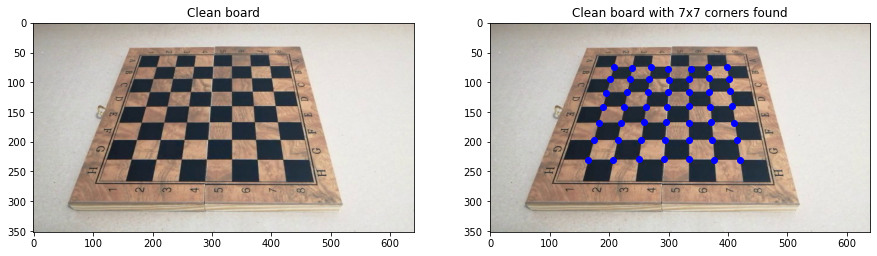

In [178]:
###Plot###
fig, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].set_title('Clean board')
axs[0].imshow(clean_board_RGB)
axs[1].set_title('Clean board with 7x7 corners found')
axs[1].imshow(clean_board_RGB)
axs[1].plot(corners7[:,:,0].reshape(-1), corners7[:,:,1].reshape(-1), 'o', color='blue')
plt.show()

### Extrapolate from 7x7 to 9x9 grid corners and refined tuning of the corners
We extrapolate the corners using the line between the two last corners on the board and the distance between them. The refined tuning is done using Linear Least-squares. You can find more information about it in the report.

In [179]:
full_corners = extrapolate_7_7_to_9_9_corners(corners7)
full_corners_new = full_corners_refined_tuning(full_corners)

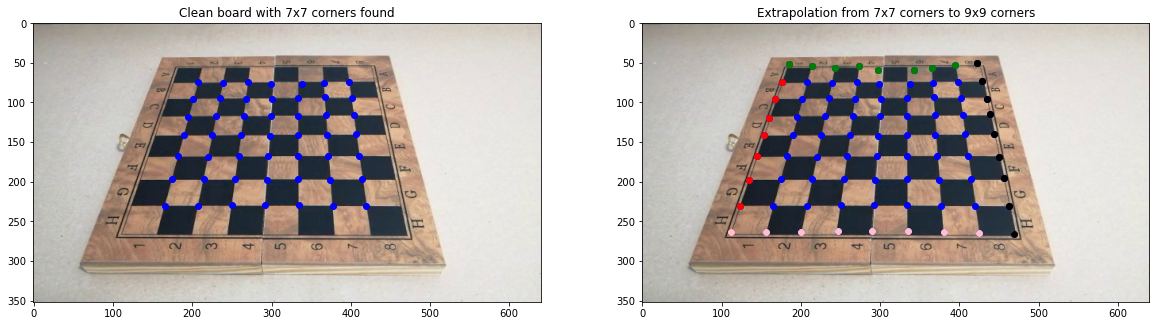

In [180]:
###Plot###
fig, axs = plt.subplots(1, 2, figsize=(20,20))
axs[0].set_title('Clean board with 7x7 corners found')
axs[0].imshow(clean_board_RGB)
axs[0].plot(corners7[:,:,0].reshape(-1), corners7[:,:,1].reshape(-1), 'o', color='blue')
axs[1].set_title('Extrapolation from 7x7 corners to 9x9 corners')
axs[1].imshow(clean_board_RGB)
axs[1].plot(full_corners[:,:,0].reshape(-1), full_corners[:,:,1].reshape(-1), 'o', color='blue')
axs[1].plot(full_corners[8,:,0], full_corners[8,:,1], 'o', color='red')
axs[1].plot(full_corners[:,0,0], full_corners[:,0,1], 'o', color='green')
axs[1].plot(full_corners[:,8,0], full_corners[:,8,1], 'o', color='pink')
axs[1].plot(full_corners[0,:,0], full_corners[0,:,1], 'o', color='black')
plt.show()

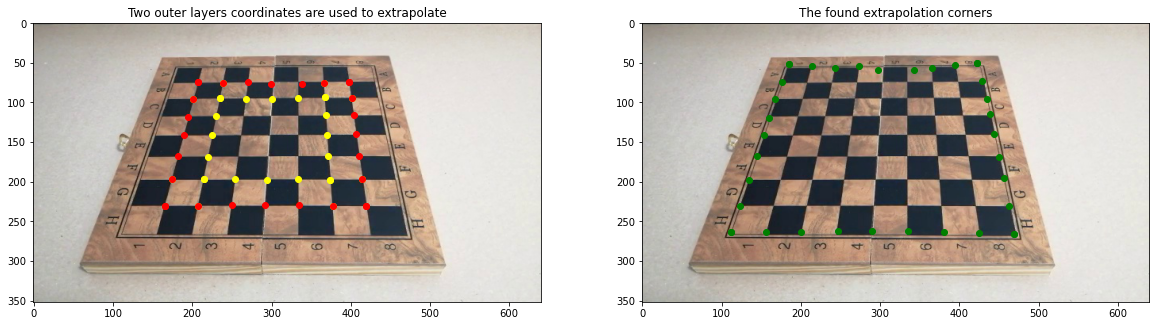

In [181]:
###Plot###
fig, axs = plt.subplots(1, 2, figsize=(20,20))
axs[0].set_title('Two outer layers coordinates are used to extrapolate')
axs[0].imshow(clean_board_RGB)
axs[0].plot(corners7[5,:,0], corners7[5,:,1], 'o', color='yellow')
axs[0].plot(corners7[:,1,0], corners7[:,1,1], 'o', color='yellow')
axs[0].plot(corners7[:,5,0], corners7[:,5,1], 'o', color='yellow')
axs[0].plot(corners7[1,:,0], corners7[1,:,1], 'o', color='yellow')

axs[0].plot(corners7[6,:,0], corners7[6,:,1], 'o', color='red')
axs[0].plot(corners7[:,0,0], corners7[:,0,1], 'o', color='red')
axs[0].plot(corners7[:,6,0], corners7[:,6,1], 'o', color='red')
axs[0].plot(corners7[0,:,0], corners7[0,:,1], 'o', color='red')


axs[1].set_title('The found extrapolation corners')
axs[1].imshow(clean_board_RGB)
axs[1].plot(full_corners[8,:,0], full_corners[8,:,1], 'o', color='green')
axs[1].plot(full_corners[:,0,0], full_corners[:,0,1], 'o', color='green')
axs[1].plot(full_corners[:,8,0], full_corners[:,8,1], 'o', color='green')
axs[1].plot(full_corners[0,:,0], full_corners[0,:,1], 'o', color='green')
plt.show()

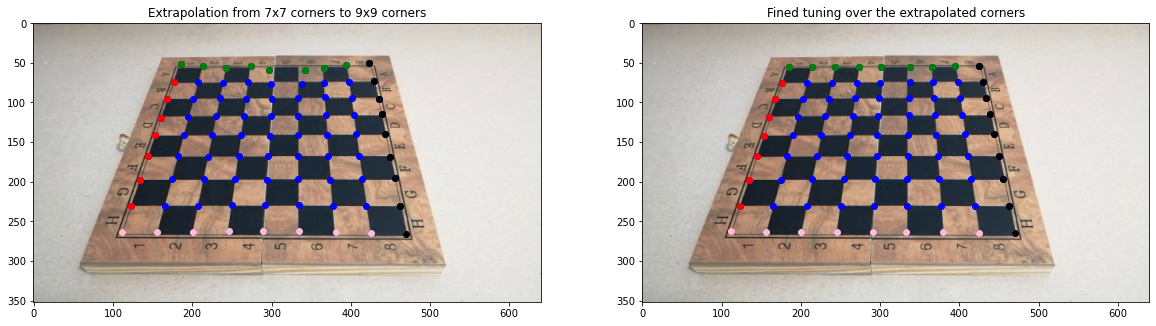

In [182]:
###Plot###
fig, axs = plt.subplots(1, 2, figsize=(20,15))
axs[0].set_title('Extrapolation from 7x7 corners to 9x9 corners')
axs[0].imshow(clean_board_RGB)
axs[0].plot(full_corners[:,:,0].reshape(-1), full_corners[:,:,1].reshape(-1), 'o', color='blue')
axs[0].plot(full_corners[8,:,0], full_corners[8,:,1], 'o', color='red')
axs[0].plot(full_corners[:,0,0], full_corners[:,0,1], 'o', color='green')
axs[0].plot(full_corners[:,8,0], full_corners[:,8,1], 'o', color='pink')
axs[0].plot(full_corners[0,:,0], full_corners[0,:,1], 'o', color='black')
axs[1].set_title('Fined tuning over the extrapolated corners')
axs[1].imshow(clean_board_RGB)
axs[1].plot(full_corners_new[:,:,0].reshape(-1), full_corners_new[:,:,1].reshape(-1), 'o', color='blue')
axs[1].plot(full_corners_new[8,:,0], full_corners_new[8,:,1], 'o', color='red')
axs[1].plot(full_corners_new[:,0,0], full_corners_new[:,0,1], 'o', color='green')
axs[1].plot(full_corners_new[:,8,0], full_corners_new[:,8,1], 'o', color='pink')
axs[1].plot(full_corners_new[0,:,0], full_corners_new[0,:,1], 'o', color='black')
plt.show()

### Extract squares 
Extract squares using full_corners_new the corners of the board after fine-tuning.

In [183]:
squares = extract_squares_from_tuned_corners(full_corners_new)

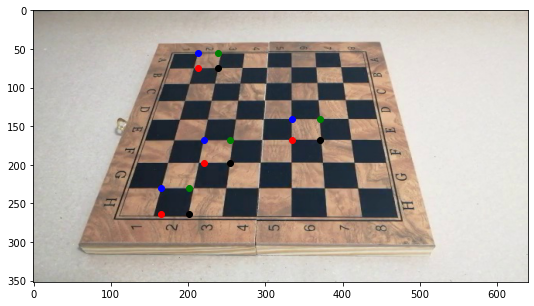

In [184]:
###Plot###
list_of_squares_to_plot = [(2,4),(5,5),(6,0),(6,7)]
fig = plt.figure(figsize=(10,5))
plt.imshow(clean_board_RGB)
for (idx1, idx2) in list_of_squares_to_plot:
    plt.plot(squares[idx1,idx2,2], squares[idx1,idx2,0], 'o', color='blue')
    plt.plot(squares[idx1,idx2,2], squares[idx1,idx2,1], 'o', color='red')
    plt.plot(squares[idx1,idx2,3], squares[idx1,idx2,0], 'o', color='green')
    plt.plot(squares[idx1,idx2,3], squares[idx1,idx2,1], 'o', color='black')
plt.show()

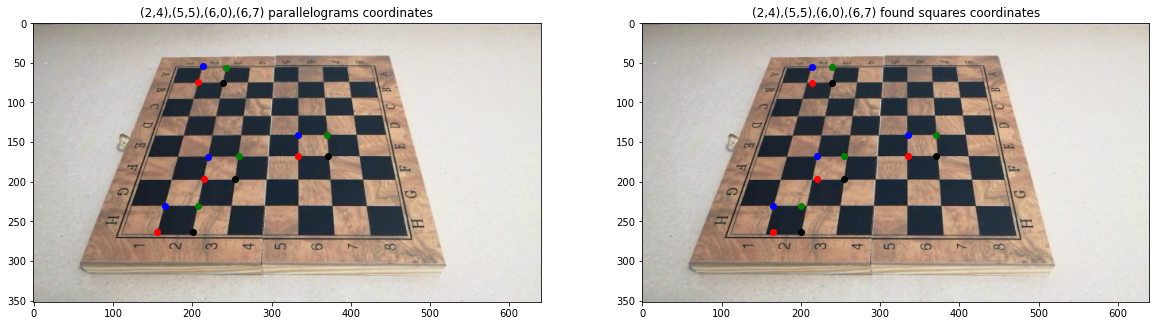

In [185]:
###Plot###
list_of_squares_to_plot = [(2,4),(5,5),(6,0),(6,7)]
fig, axs = plt.subplots(1, 2, figsize=(20,20))

axs[0].set_title('(2,4),(5,5),(6,0),(6,7) parallelograms coordinates')
axs[0].imshow(clean_board_RGB)
for (idx1, idx2) in list_of_squares_to_plot:
    axs[0].plot(full_corners[idx1+1,idx2,0], full_corners[idx1+1,idx2,1], 'o', color='blue')
    axs[0].plot(full_corners[idx1+1,idx2+1,0], full_corners[idx1+1,idx2+1,1], 'o', color='red')
    axs[0].plot(full_corners[idx1,idx2,0], full_corners[idx1,idx2,1], 'o', color='green')
    axs[0].plot(full_corners[idx1,idx2+1,0], full_corners[idx1,idx2+1,1], 'o', color='black')


axs[1].set_title('(2,4),(5,5),(6,0),(6,7) found squares coordinates')
axs[1].imshow(clean_board_RGB)
for (idx1, idx2) in list_of_squares_to_plot:
    axs[1].plot(squares[idx1,idx2,2], squares[idx1,idx2,0], 'o', color='blue')
    axs[1].plot(squares[idx1,idx2,2], squares[idx1,idx2,1], 'o', color='red')
    axs[1].plot(squares[idx1,idx2,3], squares[idx1,idx2,0], 'o', color='green')
    axs[1].plot(squares[idx1,idx2,3], squares[idx1,idx2,1], 'o', color='black')


plt.show()

## The Main Loop 
For each two following frames, calculate the difference between them, find the mean color for each one of the squarers on the board and compare it to the mean color of the original board. 
img2_gray-img1_gray+clean_board_gray classified to be the from squarer, while img1_gray-img2_gray+clean_board_gray classified to be the to squarer.

### Read frames of the game and sort them, initialize Data Structures
Read game frames from frames_moves folder, and initialize chess algebric notation and chess visualization data structures.

In [186]:
# extracting moves from the given video
path_frame_moves = "./frames_moves/" #"./frames_moves_new/"
extract_moves_from_video(path_to_video, path_frame_moves, start_sec=105,
                          thresh_pct_changed=0.001, thresholdValue=30, extract_frame0=False)

In [187]:
list_of_moves = os.listdir(path_frame_moves)
print(list_of_moves)

['.ipynb_checkpoints', 'frame3142.jpg', 'frame3292.jpg', 'frame3561.jpg', 'frame3860.jpg', 'frame4070.jpg', 'frame4339.jpg']


In [188]:
path_frame_vis = "./visualization/"
list_of_vis = os.listdir(path_frame_vis)
print(list_of_vis)

['frame1.png', 'frame2.png', 'frame3.png', 'frame4.png', 'frame5.png', 'frame6.png']


In [189]:
#load the initialized board:
if list_of_moves[0] == '.ipynb_checkpoints':
    list_of_moves = list_of_moves[1:]
path_to_strat_board = path_frame_moves + list_of_moves[0]
strat_board = cv2.imread(path_to_strat_board)
strat_board_gray = cv2.cvtColor(strat_board, cv2.COLOR_BGR2GRAY)
strat_board_RGB = cv2.cvtColor(strat_board, cv2.COLOR_BGR2RGB)

In [190]:
scaling = find_scaling_fractor(strat_board_gray, squares)
squares_names = create_squares_names(scaling)
pieces_locations = initialize_pices_on_board(squares_names)

This square location is: d3
This pices is this locations is: None


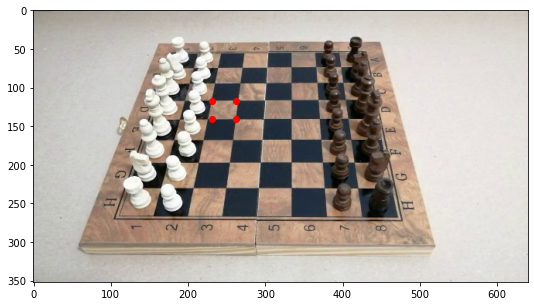

In [191]:
###Plot###
#change idx1 and idx2 and get the number of the square. 
idx1 = 5
idx2 = 3
print("This square location is:",squares_names[idx1,idx2])
print("This pices is this locations is:", pieces_locations[idx1,idx2])
fig = plt.figure(figsize=(10,5))
plt.imshow(strat_board_RGB)
plt.plot(squares[idx1,idx2,2], squares[idx1,idx2,0], 'o', color='red')
plt.plot(squares[idx1,idx2,2], squares[idx1,idx2,1], 'o', color='red')
plt.plot(squares[idx1,idx2,3], squares[idx1,idx2,0], 'o', color='red')
plt.plot(squares[idx1,idx2,3], squares[idx1,idx2,1], 'o', color='red')
plt.show()

In [192]:
# Use the cleam board mean color for comparison to the original color of the suqare. 
# Use gaussian blur to reduce noise.
# Claculate it only one time at the begining of the loop.
clean_board_b = cv2.GaussianBlur(clean_board_gray,(3,3),0)
clean_mean = mean_of_squares(clean_board_b, squares)
plot_images = True

-----------------------------------------
piece: W_P
from squarer: f2
move to squarer: f4
where there was a piece: None
white turn to play


<Figure size 432x288 with 0 Axes>

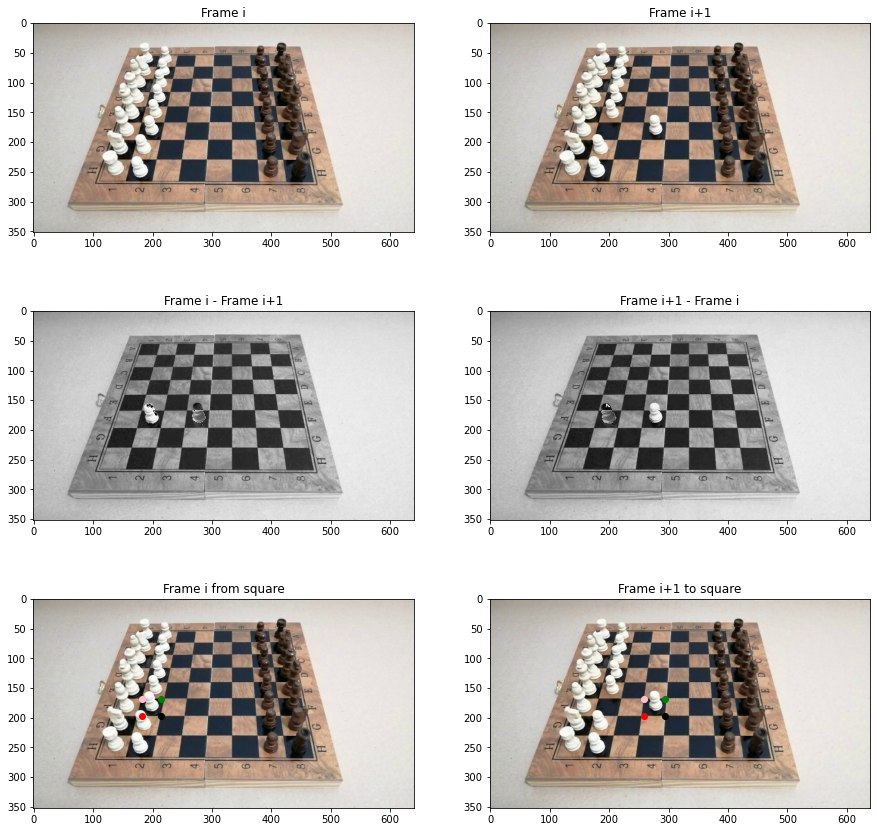

-----------------------------------------
piece: B_P
from squarer: e7
move to squarer: e5
where there was a piece: None
black turn to play


<Figure size 432x288 with 0 Axes>

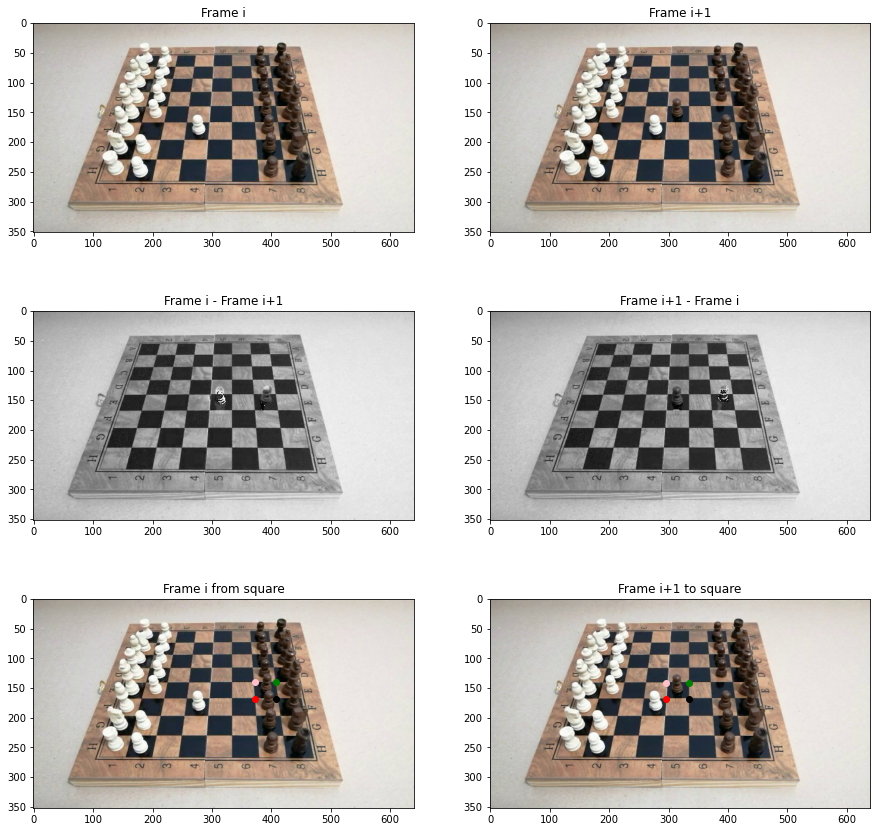

-----------------------------------------
piece: W_P
from squarer: f4
move to squarer: e5
where there was a piece: B_P
white turn to play


<Figure size 432x288 with 0 Axes>

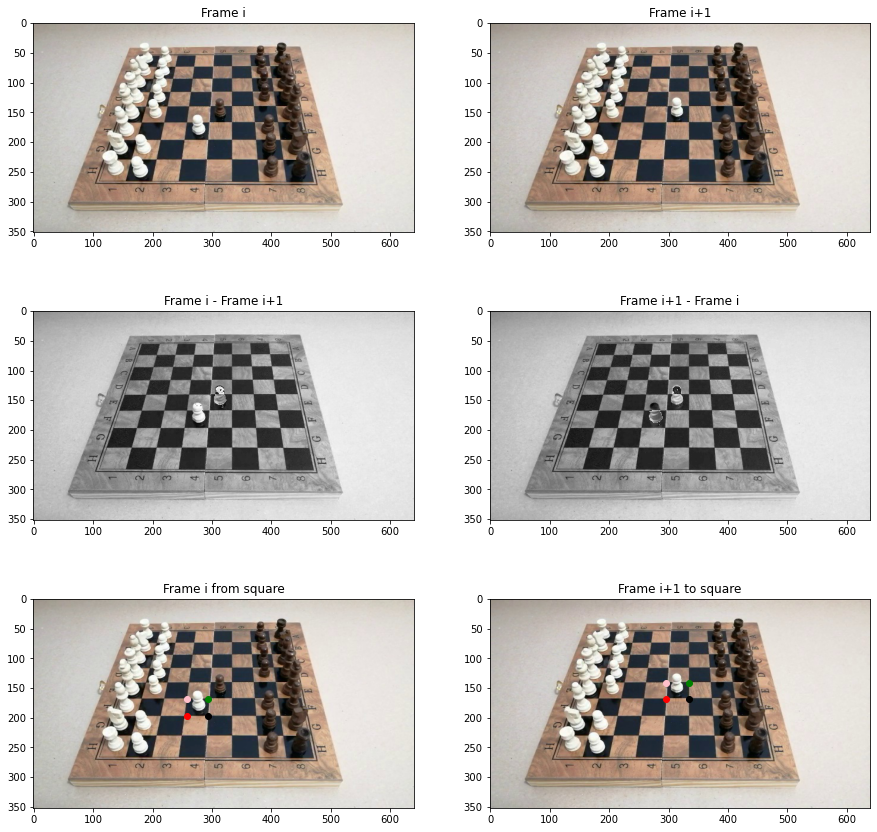

-----------------------------------------
piece: B_P
from squarer: g7
move to squarer: g5
where there was a piece: None
black turn to play


<Figure size 432x288 with 0 Axes>

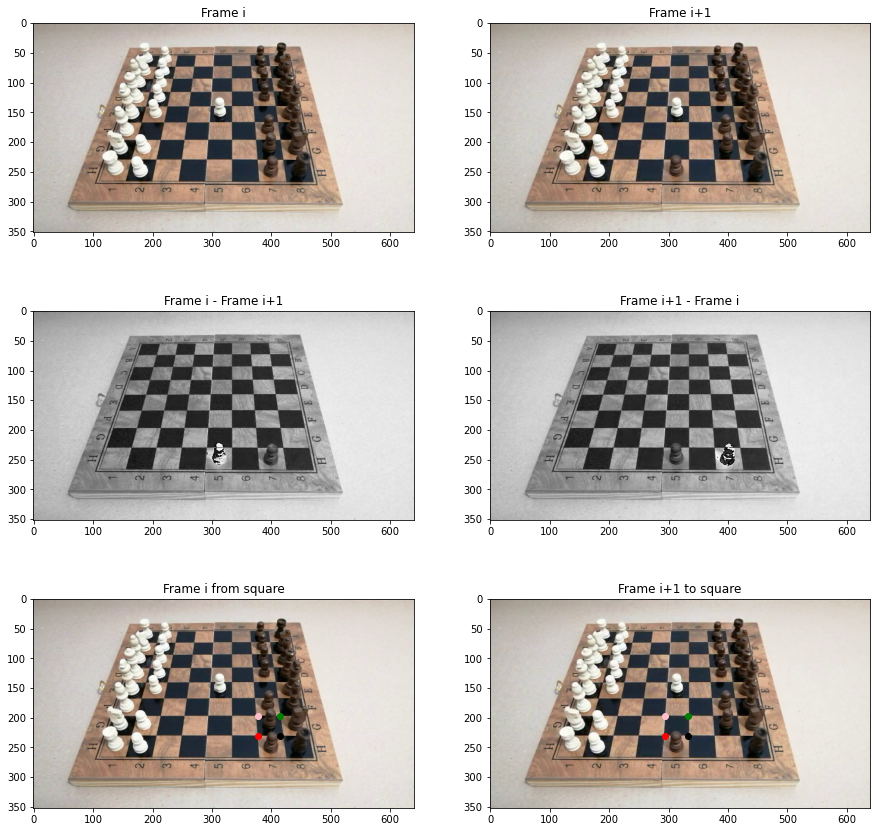

-----------------------------------------
piece: W_P
from squarer: g2
move to squarer: g3
where there was a piece: None
white turn to play


<Figure size 432x288 with 0 Axes>

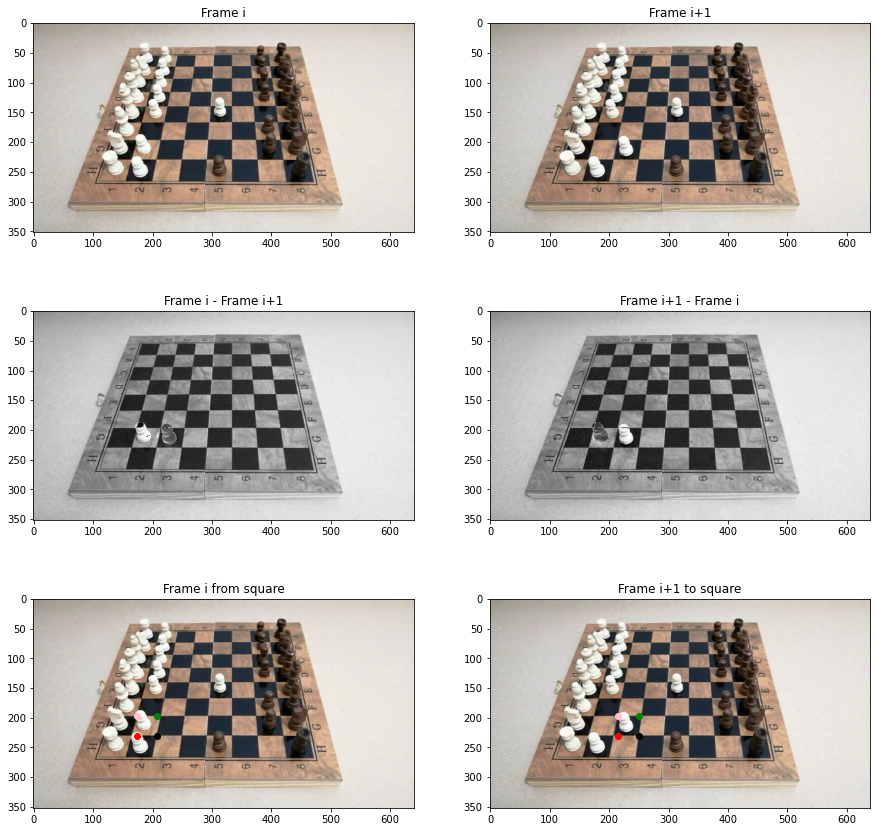

['f4', 'e5', 'fxe5', 'g5', 'g3']


In [193]:
Game_Algebraic_Notation =[]
white_move = True 

for img_idx in range(0,len(list_of_moves)-1):
    # read img1
    path_to_image1 = path_frame_moves + list_of_moves[img_idx]
    img1 = cv2.imread(path_to_image1)
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img1_RGB = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

    #read img2
    path_to_image2 = path_frame_moves + list_of_moves[img_idx+1]
    img2 = cv2.imread(path_to_image2)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    img2_RGB = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    #use gaussian blur to reduce noise (optional!) 
    img1_gray_b = cv2.GaussianBlur(img1_gray,(3,3),0)
    img2_gray_b = cv2.GaussianBlur(img2_gray,(3,3),0)

    #calculate means  

    img1_minus_img2 = img1_gray-img2_gray+clean_board_gray
    img1_minus_img2_mean = mean_of_squares(img1_minus_img2, squares)

    img2_minus_img1 = img2_gray-img1_gray+clean_board_gray
    img2_minus_img1_mean = mean_of_squares(img2_minus_img1, squares)
    
    # img1-img2+board mean compering to clean_mean and get in the max value the to square
    argmin_from = np.where((img1_minus_img2_mean - clean_mean) == (img1_minus_img2_mean - clean_mean).max())

    # img2-img1+board mean compering to clean_mean and get in the max value the from square
    argmin_to = np.where((img2_minus_img1_mean - clean_mean) == (img2_minus_img1_mean - clean_mean).max())

    from_idx1 = argmin_from[0][0]
    from_idx2 = argmin_from[1][0]
    to_idx1 = argmin_to[0][0]
    to_idx2 = argmin_to[1][0]

    from_idx1, from_idx2, to_idx1, to_idx2 = test_if_move_is_leagal(from_idx1, from_idx2, to_idx1, to_idx2, pieces_locations, white_move)
    
    print("-----------------------------------------")
    print("piece:", pieces_locations[from_idx1,from_idx2])
    print("from squarer:", squares_names[from_idx1,from_idx2])
    print("move to squarer:", squares_names[to_idx1,to_idx2])
    print("where there was a piece:", pieces_locations[to_idx1,to_idx2])
    
    if white_move == True:
        print("white turn to play")
        white_move = False
    else: 
        print("black turn to play")
        white_move = True
        
    
    # Find the algebric notation of the move 
    move_algebraic_notation, pieces_locations = find_move_algebraic_notation(from_idx1, from_idx2, to_idx1, to_idx2, squares_names, pieces_locations)
    Game_Algebraic_Notation.append(move_algebraic_notation)
    
    if plot_images == True:
        ###Plot###
        f1 = plt.figure()
        fig0, axs0 = plt.subplots(3, 2, figsize=(15,15))
        axs0[0,0].set_title('Frame i')
        axs0[0,0].imshow(img1_RGB)
        axs0[0,1].set_title('Frame i+1')
        axs0[0,1].imshow(img2_RGB)
        axs0[1,0].set_title('Frame i - Frame i+1')
        axs0[1,0].imshow(img1_minus_img2, cmap="gray")
        axs0[1,1].set_title('Frame i+1 - Frame i')
        axs0[1,1].imshow(img2_minus_img1, cmap="gray")
        axs0[2,0].set_title('Frame i from square')
        axs0[2,0].imshow(img1_RGB,cmap="gray")
        axs0[2,0].plot(squares[from_idx1,from_idx2,2], squares[from_idx1,from_idx2,0], 'o', color='pink')
        axs0[2,0].plot(squares[from_idx1,from_idx2,2], squares[from_idx1,from_idx2,1], 'o', color='red')
        axs0[2,0].plot(squares[from_idx1,from_idx2,3], squares[from_idx1,from_idx2,0], 'o', color='green')
        axs0[2,0].plot(squares[from_idx1,from_idx2,3], squares[from_idx1,from_idx2,1], 'o', color='black')
        axs0[2,1].set_title('Frame i+1 to square')
        axs0[2,1].plot(squares[to_idx1,to_idx2,2], squares[to_idx1,to_idx2,0], 'o', color='pink')
        axs0[2,1].plot(squares[to_idx1,to_idx2,2], squares[to_idx1,to_idx2,1], 'o', color='red')
        axs0[2,1].plot(squares[to_idx1,to_idx2,3], squares[to_idx1,to_idx2,0], 'o', color='green')
        axs0[2,1].plot(squares[to_idx1,to_idx2,3], squares[to_idx1,to_idx2,1], 'o', color='black')
        axs0[2,1].imshow(img2_RGB,cmap="gray")
        plt.show()
        
    
print(Game_Algebraic_Notation)
plt.show()

In [194]:
plot_for_web = True

-----------------------------------------
piece: W_P
from squarer: f2
move to squarer: f4
where there was a piece: None
white turn to play
-----------------------------------------
piece: B_P
from squarer: e7
move to squarer: e5
where there was a piece: None
black turn to play
-----------------------------------------
piece: W_P
from squarer: f4
move to squarer: e5
where there was a piece: B_P
white turn to play
-----------------------------------------
piece: B_P
from squarer: g7
move to squarer: g5
where there was a piece: None
black turn to play
-----------------------------------------
piece: W_P
from squarer: g2
move to squarer: g3
where there was a piece: None
white turn to play
['f4', 'e5', 'fxe5', 'g5', 'g3']


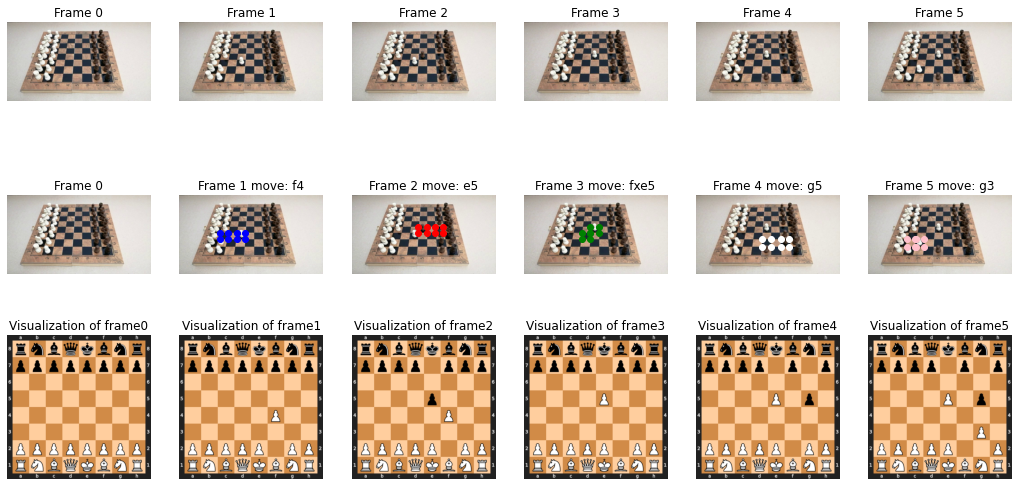

In [195]:
scaling = find_scaling_fractor(strat_board_gray, squares)
squares_names = create_squares_names(scaling)
pieces_locations = initialize_pices_on_board(squares_names)
Game_Algebraic_Notation =[]
white_move = True 

if plot_for_web == True:
    fig, axs = plt.subplots(3, len(list_of_moves), figsize=(18,9))
    colors = ['blue', 'red', 'green', 'white', 'pink', 'black', 'purple', 'gray']
for img_idx in range(0,len(list_of_moves)-1):
    # read img1
        # read img1
    path_to_image1 = path_frame_moves + list_of_moves[img_idx]
    img1 = cv2.imread(path_to_image1)
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img1_RGB = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

    #read img2
    path_to_image2 = path_frame_moves + list_of_moves[img_idx+1]
    img2 = cv2.imread(path_to_image2)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    img2_RGB = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    #use gaussian blur to reduce noise (optional!) 
    img1_gray_b = cv2.GaussianBlur(img1_gray,(3,3),0)
    img2_gray_b = cv2.GaussianBlur(img2_gray,(3,3),0)

    #calculate means  

    img1_minus_img2 = img1_gray-img2_gray+clean_board_gray
    img1_minus_img2_mean = mean_of_squares(img1_minus_img2, squares)

    img2_minus_img1 = img2_gray-img1_gray+clean_board_gray
    img2_minus_img1_mean = mean_of_squares(img2_minus_img1, squares)
    
    # img1-img2+board mean compering to clean_mean and get in the max value the to square
    diff_img1_minus_img2 = (img1_minus_img2_mean - clean_mean)
    argmin_from = np.where(diff_img1_minus_img2 == diff_img1_minus_img2.max())

    # img2-img1+board mean compering to clean_mean and get in the max value the from square
    diff_img2_minus_img1 = (img2_minus_img1_mean - clean_mean)
    argmin_to = np.where(diff_img2_minus_img1 == diff_img2_minus_img1.max())

    from_idx1 = argmin_from[0][0]
    from_idx2 = argmin_from[1][0]
    to_idx1 = argmin_to[0][0]
    to_idx2 = argmin_to[1][0]

    from_idx1, from_idx2, to_idx1, to_idx2 = test_if_move_is_leagal(from_idx1, from_idx2, to_idx1, to_idx2, pieces_locations, white_move)
    
    print("-----------------------------------------")
    print("piece:", pieces_locations[from_idx1,from_idx2])
    print("from squarer:", squares_names[from_idx1,from_idx2])
    print("move to squarer:", squares_names[to_idx1,to_idx2])
    print("where there was a piece:", pieces_locations[to_idx1,to_idx2])
    
    if white_move == True:
        print("white turn to play")
        white_move = False
    else: 
        print("black turn to play")
        white_move = True
        
    
    
    # Find the algebric notation of the move 
    move_algebraic_notation, pieces_locations = find_move_algebraic_notation(from_idx1, from_idx2, to_idx1, to_idx2, squares_names, pieces_locations)
    Game_Algebraic_Notation.append(move_algebraic_notation)

    if plot_for_web == True:
            axs[0,img_idx].set_title('Frame ' + str(img_idx))
            axs[0,img_idx].imshow(img1_RGB)
            axs[0,img_idx].set_axis_off()

            if img_idx == 0 :
                axs[1,img_idx].set_title('Frame ' + str(img_idx))
                axs[1,img_idx].imshow(img1_RGB)
                axs[1,img_idx].set_axis_off()

            axs[0,img_idx+1].set_title('Frame ' + str(img_idx+1))
            axs[0,img_idx+1].imshow(img2_RGB)
            axs[0,img_idx+1].set_axis_off()

            axs[1,img_idx+1].set_title('Frame ' + str(img_idx+1) + ' move: ' + move_algebraic_notation)
            axs[1,img_idx+1].plot(squares[from_idx1,from_idx2,2], squares[from_idx1,from_idx2,0], 'o', color=colors[img_idx])
            axs[1,img_idx+1].plot(squares[from_idx1,from_idx2,2], squares[from_idx1,from_idx2,1], 'o', color=colors[img_idx])
            axs[1,img_idx+1].plot(squares[from_idx1,from_idx2,3], squares[from_idx1,from_idx2,0], 'o', color=colors[img_idx])
            axs[1,img_idx+1].plot(squares[from_idx1,from_idx2,3], squares[from_idx1,from_idx2,1], 'o', color=colors[img_idx])
            axs[1,img_idx+1].plot(squares[to_idx1,to_idx2,2], squares[to_idx1,to_idx2,0], 'o', color=colors[img_idx])
            axs[1,img_idx+1].plot(squares[to_idx1,to_idx2,2], squares[to_idx1,to_idx2,1], 'o', color=colors[img_idx])
            axs[1,img_idx+1].plot(squares[to_idx1,to_idx2,3], squares[to_idx1,to_idx2,0], 'o', color=colors[img_idx])
            axs[1,img_idx+1].plot(squares[to_idx1,to_idx2,3], squares[to_idx1,to_idx2,1], 'o', color=colors[img_idx])
            axs[1,img_idx+1].imshow(img2_RGB)
            axs[1,img_idx+1].set_axis_off()

            axs[2,img_idx].set_title('Visualization of frame' + str(img_idx))
            axs[2,img_idx].imshow(mpimg.imread(path_frame_vis + list_of_vis[img_idx]))
            axs[2,img_idx].set_axis_off()
            axs[2,img_idx+1].set_title('Visualization of frame' + str(img_idx+1))
            axs[2,img_idx+1].imshow(mpimg.imread(path_frame_vis + list_of_vis[img_idx+1]))
            axs[2,img_idx+1].set_axis_off()
print(Game_Algebraic_Notation)            
plt.show()